# Quantum Machine Learning for Join Ordering

This notebook will demonstrate a simple example of using a variational quantum circuit (VQC) in machine learning for join order optimization.

## Imports

In [1]:
from math import pi
import csv
from collections import deque
import random
import numpy as np

# Qiskit Circuit imports
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression
from qiskit.circuit.library import TwoLocal

# Qiskit imports
import qiskit as qk
from qiskit.utils import QuantumInstance

# Qiskit Machine Learning imports
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector

# PyTorch imports
import torch
from torch import Tensor
from torch.optim import Adam

# Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline

## Create the Variational Quantum Circuit (VQC)

### Circuit Hyperparameters

In [2]:
num_qubits = 4   # Number of qubits
num_layers = 8  # Number of variational layers in the circuit

### Encoding Layer

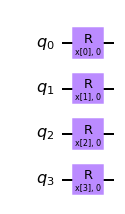

In [3]:
# Create a quantum circuit
qc = qk.QuantumCircuit(num_qubits)

# Parameters for input
x = qk.circuit.ParameterVector('x', num_qubits)

# Add encoding layer
for i in range(num_qubits):
    qc.rx(x[i], i)

# Draw the circuit 
qc.decompose().draw(output='mpl')

### Variational Layers

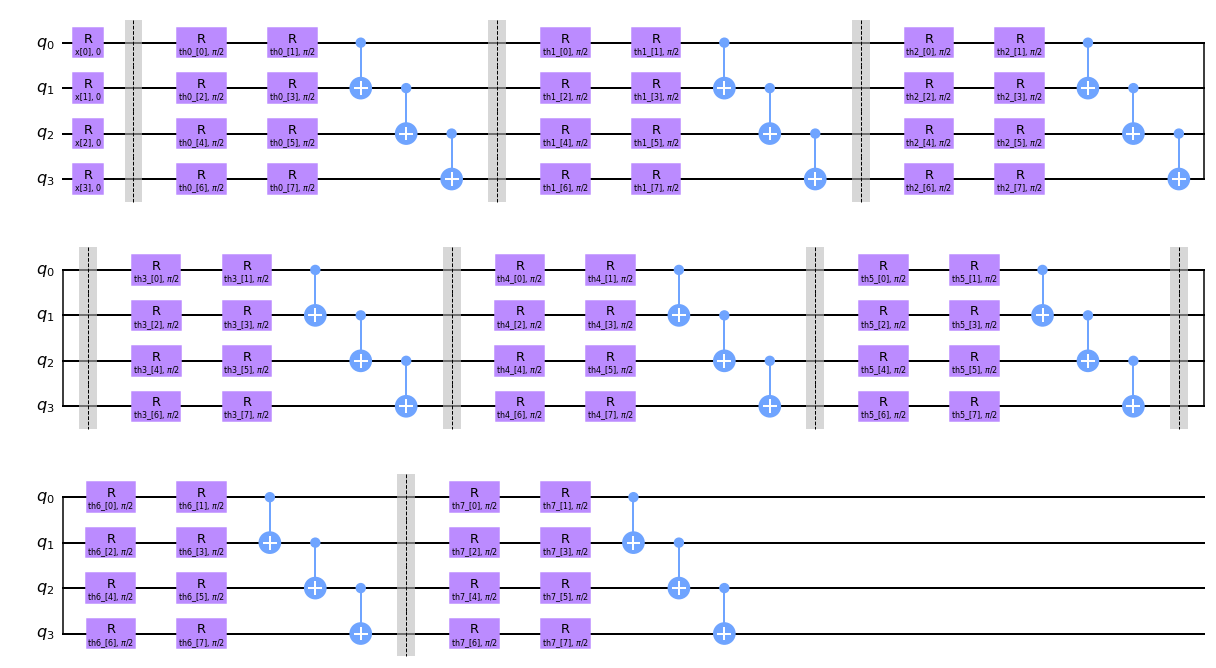

In [4]:
# Parameters for variational layers
thetas = [ qk.circuit.ParameterVector(f'th{l}_', 2*num_qubits) for l in range(num_layers) ] 

# Add variational layers
for l in range(num_layers):
    qc.barrier() # for nicer visualisation
    
    # Variational part
    for i in range(num_qubits):
        qc.ry(thetas[l][2*i], i)
        qc.ry(thetas[l][2*i+1], i)
    
    # Entangling part
    for i in range(num_qubits-1):
        qc.cx(i, i+1)

# Draw the circuit 
qc.decompose().draw(output='mpl')

## Create a Quantum Neural Network

In [5]:
# Extract the parameters to optimize
params = list(qc.parameters)[:-num_qubits]

# Select a quantum backend to run the simulation of the quantum circuit
qi = QuantumInstance(qk.Aer.get_backend('aer_simulator_statevector'))

# Create a Quantum Neural Network 
qnn = CircuitQNN(qc, input_params=x, weight_params=params, 
                 quantum_instance = qi)

### Connect to PyTorch

In [6]:
initial_weights = (np.zeros(qnn.num_weights))
quantum_nn = TorchConnector(qnn, initial_weights)

### Define layer which scales values to the interval [0,1]

In [7]:
class NormLayer(torch.nn.Module):
    def forward(self, x):
        result = x/x.max()
        return result

# Create a sequential model from the qantum network and the classical norm layer
model = torch.nn.Sequential(quantum_nn, NormLayer())

## Load data

In [8]:
with open('data.csv', newline='') as csvfile:
    data = list(csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC))

One data_row contains:

In [9]:
data_row = data[0]
print(data_row[4:])

[0.0, 0.7964358157055925, 0.8313672111312764, 0.0, 0.0, 0.0, 0.804596018735363, 0.9512026302128396, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]


### data_row[0:4] 
* **Representations of the four tables that should be joined** and angle of the encoding rotation gates. These values were created by turning each tablename into an id and mapping them to the interval $[0,\pi]$.
* ``[0.2617993877991494, 3.141592653589793, 2.0943951023931953, 1.3089969389957472]`` in this case

### data_row[4:20]
* **Rewards for the corresponding join orders** calculated from the execution times
* The reward is defined as $\frac{t_\text{chosen JO}}{t_\text{best JO}}$, where $t$ is the execution time.
* ``[0.0, 0.7964358157055925, 0.8313672111312764, 0.0, 0.0, 0.0, 0.804596018735363, 0.9512026302128396, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]`` in this case


## Train the model

1. The model can be trained by predicting rewards for a corresponding join order defined in a look-up table.
1. A loss is computed over the highest predicted reward and the actual reward stored in the data.
1. The VQCs parameters get updated via backpropagation with respect to the computed loss.

### Hyperparameters for Training

In [10]:
# Use the adam optimizer    
optimizer = Adam(model.parameters(), lr=0.005)

# Buffer to store the last 40 rewards
rewards = deque(maxlen=40)

num_steps = 30 # number of training steps

### Run the Training

In [11]:
# save loss and reward for plotting
loss_log, reward_log = [], []

for episode in range(num_steps):

    # Choose a random data entry
    entry = random.choice(data)

    # Predict rewards from the features
    prediction = model(Tensor(entry[0:4]))

    # Choose join order with highest predicted reward
    selected = prediction.argmax()

    # Store the real reward this selection would give
    rewards.append(entry[4+selected])

    # Calculate loss as sum of the squared errors
    loss = 0
    for i in range(0, len(prediction)):
        loss+= (prediction[i] - entry[4+i])**2

    # Show quality of current episode
    current_reward = sum(rewards)/len(rewards)
    print("Episode: {}, loss: {:.3f}, Reward : {:.3f}".format(episode, loss.item(), current_reward), end="\n")
    loss_log.append(loss.item())
    reward_log.append(current_reward)
    
    # Optimize using backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Episode: 0, loss: 7.483, Reward : 0.000
Episode: 1, loss: 4.346, Reward : 0.000
Episode: 2, loss: 5.383, Reward : 0.000
Episode: 3, loss: 4.962, Reward : 0.000
Episode: 4, loss: 3.330, Reward : 0.006
Episode: 5, loss: 1.659, Reward : 0.145
Episode: 6, loss: 3.030, Reward : 0.241
Episode: 7, loss: 3.549, Reward : 0.333
Episode: 8, loss: 3.116, Reward : 0.375
Episode: 9, loss: 4.285, Reward : 0.337
Episode: 10, loss: 3.925, Reward : 0.355
Episode: 11, loss: 3.729, Reward : 0.394
Episode: 12, loss: 4.232, Reward : 0.364
Episode: 13, loss: 3.201, Reward : 0.406
Episode: 14, loss: 3.096, Reward : 0.426
Episode: 15, loss: 3.352, Reward : 0.434
Episode: 16, loss: 4.071, Reward : 0.440
Episode: 17, loss: 5.065, Reward : 0.416
Episode: 18, loss: 3.486, Reward : 0.433
Episode: 19, loss: 4.215, Reward : 0.457
Episode: 20, loss: 6.351, Reward : 0.435
Episode: 21, loss: 5.482, Reward : 0.415
Episode: 22, loss: 4.234, Reward : 0.397
Episode: 23, loss: 3.459, Reward : 0.414
Episode: 24, loss: 4.705, 

## Show Training process

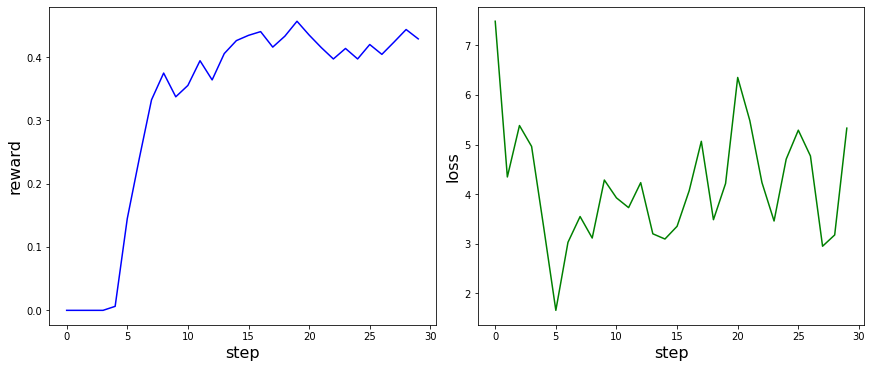

In [12]:
fig, (reward_plot, loss_plot) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout = True)

loss_plot.set_xlabel('step', fontsize = 16)
loss_plot.set_ylabel('loss', fontsize = 16)
loss_plot.plot(range(num_steps), loss_log, color="green")

reward_plot.set_xlabel('step', fontsize = 16)
reward_plot.set_ylabel('reward', fontsize = 16)
reward_plot.plot(range(num_steps), reward_log, color="blue");


## Evaluate the model for all queries

In [13]:
rewardSum = 0
for entry in data:
    # Predict rewards from the features
    prediction = model(Tensor(entry[0:4]))
    # Choose join order with highest predicted reward
    selected = prediction.argmax()
    # Store the real reward this selection would give
    rewardSum += entry[4+selected]

print("Average reward over all queries: {:.3f}".format(rewardSum/len(data)))

Average reward over all queries: 0.394


## Save model parameters

In [14]:
torch.save(model.state_dict(), "vqc.model")